In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
from pandas import DataFrame 
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/healthcare-dataset-stroke-data/test_2v.csv
/kaggle/input/healthcare-dataset-stroke-data/train_2v.csv
/kaggle/input/healthcare-dataset-stroke-data/Screen Shot 2018-04-17 at 12.15.42 AM.png


In [2]:
data_train = pd.read_csv('/kaggle/input/healthcare-dataset-stroke-data/train_2v.csv',low_memory=False,skipinitialspace=True)
data_test = pd.read_csv('/kaggle/input/healthcare-dataset-stroke-data/test_2v.csv',low_memory=False,skipinitialspace=True)

In [3]:
print(data_test.shape)
print(data_train.shape)
print(data_test.columns)
print(data_train.columns)

(18601, 11)
(43400, 12)
Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')
Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


**Since there is no stroke column available in test dataset , considering only Train dataset for whole analysis**

In [4]:
data_stroke =data_train

In [5]:
data_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [6]:
data_stroke.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

**EDA on dataset**

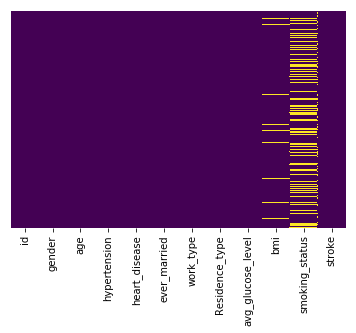

In [7]:
sns.heatmap(data_stroke.isnull(), yticklabels=False, cbar=False, cmap='viridis')

**A countplot shows the counts of observations in each categorical bin using bars.**

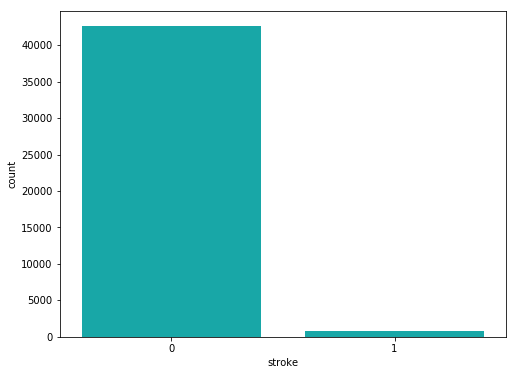

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x="stroke", data=data_stroke, color="c")
plt.show()

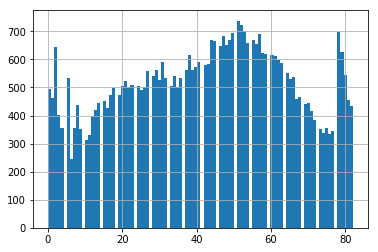

In [9]:
data_stroke['age'].hist(bins=100)

Text(0, 0.5, 'Probability Density')

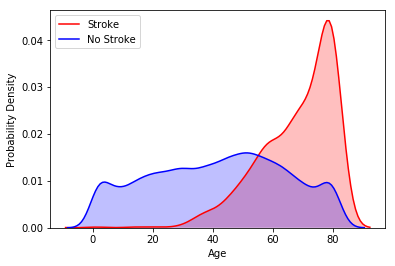

In [10]:
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==1), 
            'age'], color='r', shade=True, Label='Stroke') 
  
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==0),  
            'age'], color='b', shade=True, Label='No Stroke') 
  
plt.xlabel('Age') 
plt.ylabel('Probability Density') 

Text(0, 0.5, 'Probability Density')

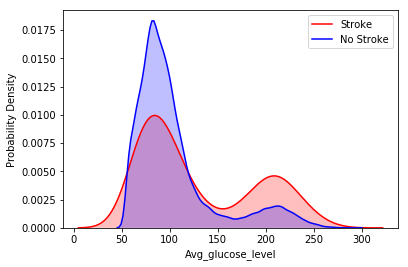

In [11]:
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==1), 
            'avg_glucose_level'], color='r', shade=True, Label='Stroke') 
  
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==0),  
            'avg_glucose_level'], color='b', shade=True, Label='No Stroke') 
  
plt.xlabel('Avg_glucose_level') 
plt.ylabel('Probability Density') 

Text(0, 0.5, 'Probability Density')

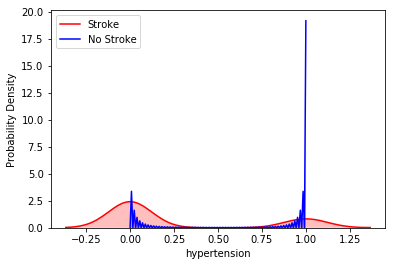

In [12]:
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==1), 
            'hypertension'], color='r', shade=True, Label='Stroke') 
  
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==0),  
            'hypertension'], color='b', shade=True, Label='No Stroke') 
  
plt.xlabel('hypertension') 
plt.ylabel('Probability Density') 

Text(0, 0.5, 'Probability Density')

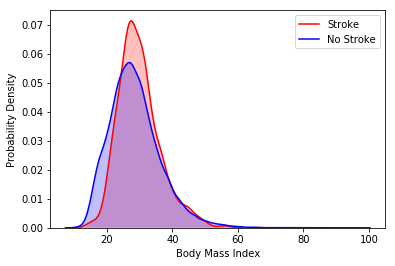

In [13]:
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==1), 
            'bmi'], color='r', shade=True, Label='Stroke') 
  
sns.kdeplot(data_stroke.loc[(data_stroke['stroke']==0),  
            'bmi'], color='b', shade=True, Label='No Stroke') 
  
plt.xlabel('Body Mass Index') 
plt.ylabel('Probability Density') 

**Handling Missing Data**

In [14]:
data_stroke['bmi'].fillna(data_stroke['bmi'].mean(),inplace=True)

**Handling the Categorical columns**

In [15]:
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
labelEncoder = LabelEncoder()
data_stroke['gender'] = labelEncoder.fit_transform(data_stroke['gender'])
data_stroke['ever_married'] = labelEncoder.fit_transform(data_stroke['ever_married'])
data_stroke['work_type'] = labelEncoder.fit_transform(data_stroke['work_type'])
data_stroke['Residence_type'] = labelEncoder.fit_transform(data_stroke['Residence_type'])

In [16]:
data_stroke.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                      0
smoking_status       13292
stroke                   0
dtype: int64

In [17]:
print(data_stroke.smoking_status.value_counts())
print(data_stroke[data_stroke.smoking_status.isnull()]['stroke'].value_counts())

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64
0    13147
1      145
Name: stroke, dtype: int64


** Dropping the smoking_status column , Since 30% of data is missing**

In [18]:
data_stroke.drop('smoking_status',axis = 1, inplace = True)

**ID column is not required in this Logistic Regression Prediction **

In [19]:
data_stroke.drop('id',axis = 1, inplace = True)

In [20]:
data_stroke.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

**UnderSampling technique**
 
since the data is imbalanced , the undersampling technique is processed

In [21]:
data_shuffled = data_stroke.sample(frac=1,random_state=4)
df_Isstroke = data_stroke.loc[data_stroke['stroke'] == 1]
df_Nostroke = data_stroke.loc[data_stroke['stroke'] == 0].sample(n= 4500,random_state= 101)

In [22]:
df_data_stroke = pd.concat([df_Isstroke,df_Nostroke])

In [23]:
df_data_stroke.stroke.value_counts()

0    4500
1     783
Name: stroke, dtype: int64

**Split the data as train and test**

In [24]:
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
df_data_stroke = shuffle(df_data_stroke)
X = df_data_stroke.drop('stroke', axis = 1)
y = df_data_stroke['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=101)

In [25]:
print('X Train dataset shapes',X_train.shape)
print('Y Train dataset shapes',y_train.shape)
print('X Test dataset shapes',X_test.shape)
print('Y Test dataset shapes',y_test.shape)

X Train dataset shapes (3698, 9)
Y Train dataset shapes (3698,)
X Test dataset shapes (1585, 9)
Y Test dataset shapes (1585,)


**Applying Logistic Regression Model**

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
logRe = LogisticRegression()
logRe.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
predictions = logRe.predict(X_test)

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
print(classification_report(y_test,predictions))
logRe.score(X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      1361
           1       0.56      0.22      0.31       224

    accuracy                           0.86      1585
   macro avg       0.72      0.60      0.62      1585
weighted avg       0.84      0.86      0.84      1585



0.8649842271293375

In [31]:
print(confusion_matrix(y_test,predictions))

[[1322   39]
 [ 175   49]]


0.5950472997795738


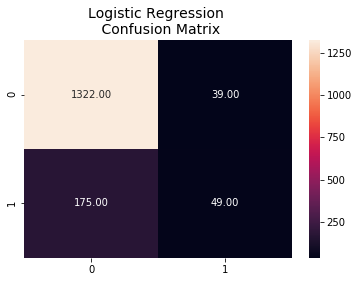

In [32]:
from sklearn import metrics
sns.heatmap(confusion_matrix(y_test,predictions), annot= True, fmt=".2f")
plt.title('Logistic Regression \n Confusion Matrix', fontsize=14)
print(roc_auc_score(y_test, predictions))

In [33]:
test_stroke = y_test.values
for i in range(0, len(test_stroke)):
    if predictions[i] == test_stroke[i]:
        print ('Pred: {0} Actual:{1}'.format(predictions[i], test_stroke[i]))
    else:
        print('Wrong Prediction')
        print ('Pred: {0} Actual:{1}'.format(predictions[i], test_stroke[i]))

Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Wrong Prediction
Pred: 1 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 1 Actual:1
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Pred: 0 Actual:0
Wrong Prediction
Pred: 0 Actual:1
Pred: 0 Actual

**StatsModel api- LogisticRegression **

In [34]:
import statsmodels.api as sm

logit_model = sm.Logit(y_train,sm.add_constant(X_train))

In [35]:
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.310942
         Iterations 8


In [36]:
print(result.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.268      
Dependent Variable: stroke           AIC:              2319.7293  
Date:               2019-11-21 13:59 BIC:              2381.8848  
No. Observations:   3698             Log-Likelihood:   -1149.9    
Df Model:           9                LL-Null:          -1570.6    
Df Residuals:       3688             LLR p-value:      2.4630e-175
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -6.2351   0.4034 -15.4565 0.0000 -7.0258 -5.4445
gender             0.1926   0.1076   1.7894 0.0736 -0.0184  0.4036
age                0.0724   0.0040  18.2756 0.0000  0.0646  0.0801
hypertension       0.

**Get the significant variables from logit model**

In [37]:
def get_significant_vars(lm):
    #Store the pvalues to corresponding columns
    df_p_vals = pd.DataFrame(lm.pvalues)
    df_p_vals['vars'] = df_p_vals.index
    df_p_vals.columns=['p_values','variables']
    return list(df_p_vals[df_p_vals['p_values']<=0.05]['variables'])

In [38]:
significant_var= get_significant_vars(result)
print(significant_var)

['const', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level']


In [39]:
if 'const' in significant_var:
    significant_var.remove('const')
    logit_model1 = sm.Logit(y_train,sm.add_constant(X_train[significant_var]))

In [40]:
final_logit = logit_model1.fit()

Optimization terminated successfully.
         Current function value: 0.311747
         Iterations 8


In [41]:
print(final_logit.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.266      
Dependent Variable: stroke           AIC:              2315.6812  
Date:               2019-11-21 13:59 BIC:              2346.7590  
No. Observations:   3698             Log-Likelihood:   -1152.8    
Df Model:           4                LL-Null:          -1570.6    
Df Residuals:       3693             LLR p-value:      1.5269e-179
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -6.4189   0.2700 -23.7718 0.0000 -6.9481 -5.8897
age                0.0715   0.0039  18.5733 0.0000  0.0640  0.0791
hypertension       0.4298   0.1292   3.3273 0.0009  0.1766  0.6831
heart_disease      0.

In [42]:
# cols_significant = significant_var.remove('const')

print(X_test[significant_var].columns)
result =final_logit.predict(sm.add_constant(X_test[significant_var]))
Y_pred_df= pd.DataFrame({"actuals":y_test,"predicted_prob":result})
Y_pred_df.sample(100,random_state=50)

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level'], dtype='object')


,actuals,predicted_prob
16198,0,0.381656
34585,0,0.017196
5278,0,0.035278
36868,1,0.168594
29920,0,0.002385
...,...,...
34692,0,0.074402
16667,0,0.390176
10569,0,0.032656
2263,1,0.419494


**Optimal classification cut off value**

Lets assume the OCC value us 0.3 as of now

In [43]:
Y_pred_df['Predicted']= Y_pred_df.predicted_prob.map(lambda x: 1 if x > 0.3 else 0)
Y_pred_df.sample(100,random_state=42)

,actuals,predicted_prob,Predicted
43299,0,0.016223,0
36889,0,0.014135,0
40827,1,0.709480,1
34502,0,0.037003,0
35948,0,0.028301,0
...,...,...,...
19140,0,0.086617,0
18416,0,0.006928,0
4728,0,0.006205,0
3252,0,0.010010,0


In [44]:
def create_cm(actuals, predicted):
    sns.heatmap(confusion_matrix(actuals,predicted), annot= True, fmt=".2f")
    plt.title('Logistic Regression \n Confusion Matrix', fontsize=14)
    plt.ylabel('True Lable')
    plt.xlabel('Predicted Lable')
    plt.show()

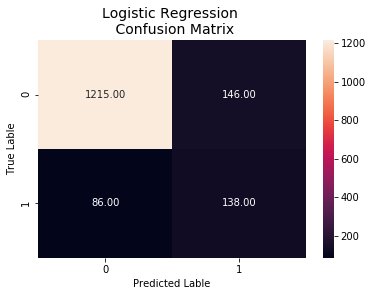

In [45]:
create_cm(Y_pred_df.actuals,Y_pred_df.Predicted)

In [46]:
print(classification_report(Y_pred_df.actuals,Y_pred_df.Predicted))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1361
           1       0.49      0.62      0.54       224

    accuracy                           0.85      1585
   macro avg       0.71      0.75      0.73      1585
weighted avg       0.87      0.85      0.86      1585



In [47]:
def create_roc_auc(actuals, predicted):
    logit_roc_auc = roc_auc_score(actuals, predicted)
    fpr, tpr, thresholds = roc_curve(actuals, predicted )
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

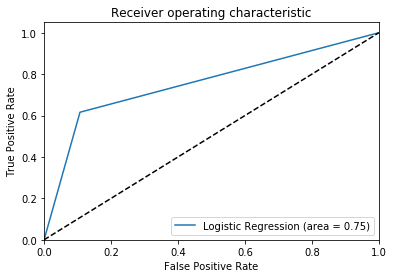

In [48]:
create_roc_auc(Y_pred_df.actuals,Y_pred_df.Predicted)